# This is one big notebook containing all the code for the synthetic data research as part of the Master Thesis of Daniël de Bondt

Synthetic data is generated in three specific ways. 

1) _balance_ with two distinct linear features and two nonlinear features whose effects are balanced with a lambda nonlinearity parameter

2) _noise_ with a linear data structure, but increasing levels of noise in data generation

3) _combined_ with four 


In [96]:
cd ..

C:\Users\danie\Documents\StageDaniel


In [97]:
cd research

C:\Users\danie\Documents\StageDaniel\research


In [98]:
import numpy as np
import pandas as pd

def create_synth_data(balance, name = 'Synthetic Data', save=False, combined=False, size = 5000, noise_sd = 1, seed = 10, 
                      linear_coefficients = [0, 0, 0.4, 0.4],
                      Age_effects = [-4, -2, 2, 4, -2], 
                      Edu_effects = [ -4, -3, -1, 2, 6]):
    np.random.seed(seed)
    
    # continuous variables
    Age = np.random.randint(18, 70, size=size)
    Education = np.round(np.random.normal(10, 2.5,size=size),0)
    Experience = np.random.randint(0, 20, size=size)
    Hours = np.round(np.random.normal(40,2, size=size),0)

    # create X dataframe
    X_dict = {"Age": Age, "Education":Education, "Experience": Experience, "Hours": Hours}
    columns = ["Age", "Education", "Experience", "Hours"]
    X = pd.DataFrame(X_dict)

    # apply linear coefficients to explanations
    explanations = X.apply(lambda x: x * linear_coefficients, axis=1)
    
    # apply piecewise nonlinearity to explanations
    Age_explanations = pd.cut(X['Age'],len(Age_effects), labels=False).apply(lambda x: Age_effects[x])
    Edu_explanations = pd.cut(X['Education'],len(Edu_effects), labels=False).apply(lambda x: Edu_effects[x])
    
    if not combined:
        # redefine balance between linearity and nonlinearity based on input variable balance
        explanations['Age'] = Age_explanations * balance
        explanations['Education'] = Edu_explanations * balance
        explanations['Experience'] = explanations['Experience'] * (1-balance)
        explanations['Hours'] = explanations['Hours'] * (1-balance)
    else:
        Exp_effects = [-4, -1, 2, 4, 5] 
        Hrs_effects = [2, -4, -2, 2, 4] 
        Exp_explanations = pd.cut(X['Experience'],len(Exp_effects), labels=False).apply(lambda x: Exp_effects[x])
        Hrs_explanations = pd.cut(X['Hours'],len(Hrs_effects), labels=False).apply(lambda x: Hrs_effects[x])
        
        explanations['Age'] = explanations['Age'] * (1-balance) + Age_explanations * balance
        explanations['Education'] = explanations['Education'] * (1-balance) + Edu_explanations * balance
        explanations['Experience'] = explanations['Experience'] * (1-balance) + Exp_explanations * balance
        explanations['Hours'] = explanations['Hours'] * (1-balance) + Hrs_explanations * balance
    
    # add noise, determine label y and reorder columns
    data = X.copy()
    noise = np.random.normal(scale = noise_sd, size=size)
    data['y'] = (explanations.sum(axis=1)+noise>explanations.sum(axis=1).mean()).astype(int)
    data = data[['y'] + columns]
    
    if save:
        data.to_csv('synthetic_data/data/'+name+'_processed.csv', index=False)
        explanations.to_csv('synthetic_data/explanations/'+name+'.csv', index=False)
    
    return data, explanations

In [99]:
data, explanations = create_synth_data(balance = 0.5, save=False)

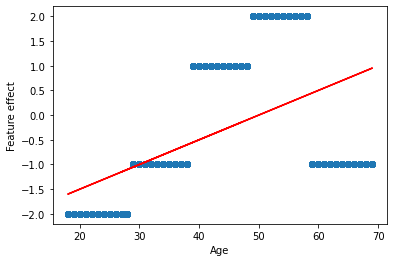

In [100]:
import matplotlib.pyplot as plt
plt.xlabel("Age")
plt.ylabel("Feature effect")
plt.scatter(data.Age, explanations.Age)
y = data.Age*0.05-2.5
plt.plot(data.Age, y, '-r', label='y=2x+1')
plt.savefig("results\plots\synth_nonlinear.png")
plt.show()

In [14]:
for balance in [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]:
    data, explanations = create_synth_data(balance, name = "synth_adult_balance_"+str(balance), save=True)

In [135]:
for noise in [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 10]:
    data, explanations = create_synth_data(balance=0, name = "synth_adult_noise_alt"+str(noise), noise_sd=noise, save=True, combined=True, linear_coefficients = [0.4, 0.4, 0.4, 0.4])

In [134]:
for balance in [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]:
    data, explanations = create_synth_data(balance, name = "synth_adult_combined_alt_"+str(balance), save=True, combined=True, linear_coefficients = [0.4, 0.4, 0.4, 0.4])

In [48]:
explanations.head()

,Age,Education,Experience,Hours
0,-4.0,-3.0,-2.0,-1.0
1,4.0,-1.0,-4.0,-1.0
2,-2.0,2.0,4.0,-3.0
3,-4.0,-1.0,2.0,2.0
4,-2.0,-1.0,4.0,-1.0


In [49]:
data.head()

,y,Age,Education,Experience,Hours
0,0,27,8.0,7,39.0
1,0,54,11.0,3,40.0
2,1,33,13.0,15,38.0
3,1,18,10.0,8,42.0
4,1,67,12.0,14,40.0


In [73]:
## import standard modules for data handling and visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## import model specific modules
import cplex as cp
import slim_python as slim
import shap
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

## import additional functionalities
from interpret import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, zero_one_loss, accuracy_score
from sklearn import metrics

pd.set_option('display.max_columns', None)

Auxiliary Functions

In [74]:
## SLIM requires the data in a specific non dataframe format, this code prepares that
def prep_data(X_train, y_train, X_test, y_test):
    # requirements for slim data file
    # - outcome variable in first column
    # - outcome variable values should be [-1, 1] or [0, 1]
    # - first row contains names for the outcome variable + input variables
    # - no empty cells
    
    N_train = X_train.values.shape[0]
    N_test = X_test.values.shape[0]

    # setup Y vector and Y_name
    y_name = y_test.name
    y_train_slim = y_train.copy().values.reshape(len(y_train),1)
    y_train_slim[y_train_slim == 0] = -1
    y_test_slim = y_test.copy().values.reshape(len(y_test),1)
    y_test_slim[y_test_slim == 0] = -1

    # setup X and X_names
    X_names = list(X_train.columns.values)
    X_train_slim = X_train.values
    X_test_slim = X_test.values
    

    # insert a column of ones to X for the intercept
    X_train_slim = np.insert(arr = X_train_slim, obj = 0, values = np.ones(N_train), axis = 1)
    X_test_slim = np.insert(arr = X_test_slim, obj = 0, values = np.ones(N_test), axis = 1)
    X_names.insert(0, '(Intercept)')

    # run sanity checks
    slim.check_data(X = X_train_slim, Y = y_train_slim, X_names = X_names)      
    
    return (X_train_slim, X_test_slim, y_train_slim, y_test_slim, X_names, y_name)

## Simple function for getting predictions for a SLIM scoring system
def pred_slim(X, rho):
    return (X.dot(rho[1:])+rho[0]>=0)*1

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def scale_sigmoid(x):
    x_max = np.maximum(x.max(), np.abs(x.min()))
    x = x/(x_max/5)
    return 1/(1 + np.exp(-x))

def auc(y, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)
    return metrics.auc(fpr, tpr)

Models

In [75]:
def train_slim(X, X_names, Y, y_name, params={}, timelimit=600.0, silent=True):
    #### TRAIN SCORING SYSTEM USING SLIM ####
    # setup SLIM coefficient set
    coef_constraints = slim.SLIMCoefficientConstraints(variable_names = X_names, ub = 5, lb = -5)
    #choose upper and lower bounds for the intercept coefficient
    #to ensure that there will be no regularization due to the intercept, choose
    #
    #intercept_ub < min_i(min_score_i)
    #intercept_lb > max_i(max_score_i)
    #
    #where min_score_i = min((Y*X) * \rho) for rho in \Lset
    #where max_score_i = max((Y*X) * \rho) for rho in \Lset
    #
    #setting intercept_ub and intercept_lb in this way ensures that we can always
    # classify every point as positive and negative
    scores_at_ub = (Y * X) * coef_constraints.ub
    scores_at_lb = (Y * X) * coef_constraints.lb
    non_intercept_ind = np.array([n != '(Intercept)' for n in X_names])
    scores_at_ub = scores_at_ub[:, non_intercept_ind]
    scores_at_lb = scores_at_lb[:, non_intercept_ind]
    max_scores = np.fmax(scores_at_ub, scores_at_lb)
    min_scores = np.fmin(scores_at_ub, scores_at_lb)
    max_scores = np.sum(max_scores, 1)
    min_scores = np.sum(min_scores, 1)

    intercept_ub = -min(min_scores) + 1
    intercept_lb = -max(max_scores) + 1
    coef_constraints.set_field('ub', '(Intercept)', intercept_ub)
    coef_constraints.set_field('lb', '(Intercept)', intercept_lb)
#     coef_constraints.view()
    
#     w_pos = 1.905
#     w_neg = 0.095
    w_pos = 1.0
    w_neg = 1.0
    
    #create SLIM IP
    if not params:
        slim_input = {
            'X': X,
            'X_names': X_names,
            'Y': Y,
            'C_0': 0.001,
            'w_pos': w_pos,
            'w_neg': w_neg,
            'L0_min': 0,
            'L0_max': float('inf'),
            'err_min': 0,
            'err_max': 1.0,
            'pos_err_min': 0,
            'pos_err_max': 1.0,
            'neg_err_min': 0,
            'neg_err_max': 1.0,
            'coef_constraints': coef_constraints
        }
    else:
        slim_input = params
        
    

    slim_IP, slim_info = slim.create_slim_IP(slim_input)
    
    if silent:
        slim_IP.set_log_stream(None)
        slim_IP.set_error_stream(None)
        slim_IP.set_warning_stream(None)
        slim_IP.set_results_stream(None)
    
    # setup SLIM IP parameters
    # see docs/usrccplex.pdf for more about these parameters
    slim_IP.parameters.timelimit.set(timelimit) #set runtime here
    #TODO: add these default settings to create_slim_IP
    slim_IP.parameters.randomseed.set(0)
    slim_IP.parameters.threads.set(1)
    slim_IP.parameters.parallel.set(1)
    slim_IP.parameters.output.clonelog.set(0)
    slim_IP.parameters.mip.tolerances.mipgap.set(np.finfo(np.float).eps)
    slim_IP.parameters.mip.tolerances.absmipgap.set(np.finfo(np.float).eps)
    slim_IP.parameters.mip.tolerances.integrality.set(np.finfo(np.float).eps)
    slim_IP.parameters.emphasis.mip.set(1)


    # solve SLIM IP
    slim_IP.solve()

    # run quick and dirty tests to make sure that IP output is correct
    slim.check_slim_IP_output(slim_IP, slim_info, X, Y, coef_constraints)
    
    return slim_IP, slim_info
        
    
def train_ebm(X, y, params={}):
    
    if not params:
        n_estimators = 100
        learning_rate = 1.0
        random_state=0
    else:
        n_estimators=params['n_estimators']
        learning_rate = params['learning_rate']
        random_state = params['random_state']
        
    ebm = ExplainableBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state).fit(X, y)
    return ebm

def train_shap(X, y, params={}):

    if not params:
        gamma = 0.5
        n_estimators = 600
        objective = 'binary:logistic'
        silent=True
        nthread=1
    else:
        gamma = params['gamma']
        n_estimators = params['n_estimators']
        objective = params['objective']
        silent = params['silent']
        nthread = params['nthread']
        
    model = XGBClassifier(max_depth=4,
        gamma=gamma,
        n_estimators=n_estimators,
        objective=objective,
        silent=silent,
        nthread=nthread)
    model.fit(X, y)
    return model

def train_logit(X, y, params={}):
    if not params:
        penalty='l1'
        solver = 'liblinear'
        C = 0.01
    else:
        penalty = params['penalty']
        solver = params['solver']
        C = params['C']
    logit = LogisticRegression(penalty=penalty, solver=solver, C=C).fit(X, y)
    return logit

def run_all(X_train, y_train, X_test, y_test, params=None, timelimit=3600):
    ## runs all three models in consecutive order
    
    ## SLIM needs specially prepared data
    X_train_slim, X_test_slim, y_train_slim, y_test_slim, X_names, y_name = prep_data(X_train, y_train, X_test, y_test)
    print('-----------------------------------------')
    print("Running Supersparse Linear Integer Model")
    print("Max runtime: ", timelimit, 'seconds')
    slim_model, slim_info = train_slim(X_train_slim, X_names, y_train_slim, y_name, timelimit=timelimit)
    slim_results = slim.get_slim_summary(slim_model, slim_info, X_train_slim, y_train_slim)
    slim_results_test = slim.get_slim_summary(slim_model, slim_info, X_test_slim, y_test_slim)
#     print(slim_results['string_model'])
    print('train accuracy: ', (1-slim_results['error_rate']))
    print('test accuracy: ',  (1-slim_results_test['error_rate']))
    slim_object = (slim_info, slim_results)
#     slim_object = (slim_info, slim_model)
       
    print('-----------------------------------------')
    print("Running Explainable Boosting Machine")
    ebm = train_ebm(X_train, y_train)
    print('train accuracy: ', ebm.score(X_train, y_train))
    print('test accuracy: ', ebm.score(X_test, y_test))
    
    print('-----------------------------------------')
    print("Running SHAP explained XGBoost")
    shap = train_shap(X_train, y_train)
    print('train accuracy: ', accuracy_score(y_train, shap.predict(X_train)))
    print('test accuracy: ', accuracy_score(y_test, shap.predict(X_test)))
    
    print('-----------------------------------------')
    print("Running Logit")
    logit = train_logit(X_train, y_train, params[0])
    print('train accuracy: ', logit.score(X_train, y_train))
    print('test accuracy: ', logit.score(X_test, y_test))
    
    return (slim_object, ebm, shap, logit)

In [76]:
def save_results(results, name ):
    with open('synthetic_data/models/'+ name + '.pkl', 'wb') as f:
        pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

def run_results(dataframe, dataset, save=True, timelimit=200):
    # Select X and y from the data and split into train and test set
    features = dataframe.columns[1:]
    label = dataframe.columns[0]
    X = dataframe[features]
    X_names = list(X.columns.values)
    X_names.insert(0, '(Intercept)')
    y = dataframe[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 10 fold
    
    params = [{'C': 1, 'penalty':'l1', 'solver' : 'liblinear'}]

    # Run the models, displaying in- and out-of-sample performance
    results = run_all(X_train, y_train, X_test, y_test, params, timelimit=timelimit)
    del results[0][1]['pretty_model']
    datasplit = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test,'y_test': y_test}
    
    if save:
        save_results(results[:], dataset + '_models')
        save_results(datasplit, dataset + '_data')
    return (results, datasplit)
    

In [58]:
for balance in [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]:
    name = "synth_adult_balance_"+str(balance)
    dataframe = pd.read_csv(os.getcwd() + '/synthetic_data/data/'+ name + '_processed.csv', sep = ',')
    models, data = run_results(dataframe, name)

-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.89625
test accuracy:  0.897
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.9035
test accuracy:  0.887
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.92175
test accuracy:  0.891
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.89675
test accuracy:  0.899
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.8785000000000001
test accuracy:  0.882
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.89325
test accuracy:  0.878
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9225
test accuracy:  0.879
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.882
test accuracy:  0.881
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.8452500000000001
test accuracy:  0.832
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.88375
test accuracy:  0.867
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.90925
test accuracy:  0.868
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.8545
test accuracy:  0.853
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.80425
test accuracy:  0.815
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.87225
test accuracy:  0.868
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9035
test accuracy:  0.866
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.8205
test accuracy:  0.826
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.7697499999999999
test accuracy:  0.738
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.86525
test accuracy:  0.85
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.89975
test accuracy:  0.831
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.76875
test accuracy:  0.777
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.728
test accuracy:  0.704
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.881
test accuracy:  0.877
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.90325
test accuracy:  0.875
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.70675
test accuracy:  0.71
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.7464999999999999
test accuracy:  0.719
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.896
test accuracy:  0.899
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.92025
test accuracy:  0.888
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.688
test accuracy:  0.668
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.7585
test accuracy:  0.734
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.926
test accuracy:  0.92
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.948
test accuracy:  0.923
-----------------------------------------
Running Logit
train accuracy:  0.671
test accuracy:  0.665
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.76375
test accuracy:  0.742
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.944
test accuracy:  0.945
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.953
test accuracy:  0.939
-----------------------------------------
Running Logit
trai

In [136]:
for noise in [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 10]:
    name = "synth_adult_noise_alt"+str(noise)
    dataframe = pd.read_csv(os.getcwd() + '/synthetic_data/data/'+ name + '_processed.csv', sep = ',')
    models, data = run_results(dataframe, name, timelimit=200)

-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  1.0
test accuracy:  1.0
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.9995
test accuracy:  0.994
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9995
test accuracy:  0.985
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.988
test accuracy:  0.987
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.9815
test accuracy:  0.978
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.9855
test accuracy:  0.976
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9945
test accuracy:  0.968
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.979
test accuracy:  0.97
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.93625
test accuracy:  0.9299999999999999
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.96075
test accuracy:  0.962
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.97225
test accuracy:  0.958
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.9575
test accuracy:  0.96
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.93375
test accuracy:  0.929
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.94075
test accuracy:  0.946
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.95025
test accuracy:  0.951
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.93575
test accuracy:  0.942
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.9095
test accuracy:  0.902
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.9215
test accuracy:  0.919
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9325
test accuracy:  0.911
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.9165
test accuracy:  0.915
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.8674999999999999
test accuracy:  0.859
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.903
test accuracy:  0.899
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.92225
test accuracy:  0.896
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.89875
test accuracy:  0.898
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.8775
test accuracy:  0.876
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.8865
test accuracy:  0.889
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.90125
test accuracy:  0.881
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.88225
test accuracy:  0.884
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.84675
test accuracy:  0.836
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.853
test accuracy:  0.869
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.87175
test accuracy:  0.865
-----------------------------------------
Running Logit
train accuracy:  0.85
test accuracy:  0.862
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.80775
test accuracy:  0.802
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.8205
test accuracy:  0.823
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.842
test accuracy:  0.814
-----------------------------------------
Running Logi

Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.699
test accuracy:  0.712


In [103]:
for balance in [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]:
    name = "synth_adult_combined_alt_"+str(balance)
    dataframe = pd.read_csv(os.getcwd() + '/synthetic_data/data/'+ name + '_processed.csv', sep = ',')
    models, data = run_results(dataframe, name)

-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.94675
test accuracy:  0.949
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.96075
test accuracy:  0.962
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.97225
test accuracy:  0.958
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.957
test accuracy:  0.961
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.947
test accuracy:  0.937
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.9625
test accuracy:  0.959
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.97175
test accuracy:  0.953
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.95375
test accuracy:  0.961
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.93225
test accuracy:  0.925
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.95925
test accuracy:  0.954
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.96875
test accuracy:  0.949
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.95075
test accuracy:  0.954
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.93125
test accuracy:  0.929
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.959
test accuracy:  0.954
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9685
test accuracy:  0.947
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.942
test accuracy:  0.953
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.914
test accuracy:  0.926
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.953
test accuracy:  0.948
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.96675
test accuracy:  0.946
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.917
test accuracy:  0.928
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.86825
test accuracy:  0.871
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.94325
test accuracy:  0.936
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9635
test accuracy:  0.926
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.87175
test accuracy:  0.872
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.84125
test accuracy:  0.861
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.94375
test accuracy:  0.933
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9585
test accuracy:  0.927
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.845
test accuracy:  0.862
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.8109999999999999
test accuracy:  0.792
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.9505
test accuracy:  0.923
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9635
test accuracy:  0.917
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.82575
test accuracy:  0.826
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.7565
test accuracy:  0.77
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.94075
test accuracy:  0.93
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.95475
test accuracy:  0.921
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.8075
test accuracy:  0.81
-----------------------------------------
Running Supersparse Linear Integer Model
Max runtime:  200 seconds
train accuracy:  0.75825
test accuracy:  0.785
-----------------------------------------
Running Explainable Boosting Machine
train accuracy:  0.94525
test accuracy:  0.94
-----------------------------------------
Running SHAP explained XGBoost
train accuracy:  0.9585
test accuracy:  0.927
-----------------------------------------
Running Logit


Liblinear failed to converge, increase the number of iterations.


train accuracy:  0.78775
test accuracy:  0.799


In [28]:
def extract_results(results, X):
    # Extract specific models from the results

    slim_results = results[0][1]

    rho = slim_results['rho']
    slim_predictions = pred_slim(X,rho)

    ebm = results[1]

    XGboost = results[2]
    explainer = shap.TreeExplainer(XGboost)
    shap_values = explainer.shap_values(X)

    logit = results[3]
    
    return rho, slim_predictions, ebm, explainer, shap_values, logit


def get_explanations(results, X, y, X_names, pred_idx=0, printing=False):
    
    rho, slim_predictions, ebm, explainer, shap_values, logit = results   
    
    observation = pd.Series(1, index=['Constant']).append(X.iloc[pred_idx]).append(pd.Series(y.iloc[pred_idx], index=['prediction']))
    
    slim_contributions = X.iloc[pred_idx]*rho[1:]
    slim_threshold = rho[0]
    slim_prediction = slim_predictions.iloc[pred_idx]
    slim_explanation = pd.Series(slim_threshold, index=['Constant']).append(slim_contributions).append(pd.Series(slim_prediction, index=['prediction'])) 

    logit_contributions = X.iloc[pred_idx]*logit.coef_.ravel()
    logit_intercept = logit.intercept_
    logit_prediction = int(sum(logit_contributions)+logit_intercept>0)
    logit_explanation = pd.Series(logit_intercept, index=['Constant']).append(logit_contributions).append(pd.Series(logit_prediction, index=['prediction']))

    ebm_local = ebm.explain_local(X.iloc[pred_idx:pred_idx+1], y.iloc[pred_idx:pred_idx+1], name='EBM')
    ebm_contributions = pd.Series(ebm_local.data(0)['scores'], index=X_names[1:])
    ebm_mean = ebm_local.data(0)['extra']['scores'][0]                               
    ebm_prediction = int(sum(ebm_contributions)+ebm_mean>0)
    ebm_explanation = pd.Series(ebm_mean, index= ['Constant']).append(ebm_contributions).append(pd.Series(ebm_prediction, index=['prediction']))

    shap_contributions = pd.Series(shap_values[pred_idx,:], index=X_names[1:])
    shap_mean = explainer.expected_value                              
    shap_prediction =  int(sum(shap_contributions)+ shap_mean>0)
    shap_explanation = pd.Series(shap_mean, index = ['Constant']).append(shap_contributions).append(pd.Series(shap_prediction, index=['prediction']))
    
    explanations = pd.DataFrame([observation, slim_explanation, logit_explanation, ebm_explanation, shap_explanation], index=['X', 'slim', 'logit', 'ebm', 'shap'])
    explanations['sum'] = explanations[list(explanations.columns)].sum(axis=1)
    if printing:
        display(explanations)
        print("prediction slim: ", slim_prediction)
        print("prediction logit: ", logit_prediction)
        print("prediction ebm: ", ebm_prediction)
        print("prediction shap: ", shap_prediction)
        print("true y: ", y.iloc[pred_idx])   
    
    return explanations

def performance_measures(data, models):
    train_aucs = []
    test_aucs = []
    
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    slim_results = models[0][1]
    rho = slim_results['rho']
    train_pred = scale_sigmoid(X_train.dot(rho[1:])+rho[0])
    test_pred = sigmoid(X_test.dot(rho[1:])+rho[0])
    train_aucs.append(auc(y_train,train_pred))
    test_aucs.append(auc(y_test,test_pred))
    
    ebm = models[1]
    train_pred = ebm.predict_proba(X_train)
    test_pred = ebm.predict_proba(X_test)
    train_aucs.append(auc(y_train,train_pred[:,1]))
    test_aucs.append(auc(y_test,test_pred[:,1]))
    
    XGBoost = models[2]
    train_pred = XGBoost.predict_proba(X_train)
    test_pred = XGBoost.predict_proba(X_test)
    train_aucs.append(auc(y_train,train_pred[:,1]))
    test_aucs.append(auc(y_test,test_pred[:,1]))
    
    logit = models[3]
    train_pred = logit.predict_proba(X_train)
    test_pred = logit.predict_proba(X_test)
    train_aucs.append(auc(y_train,train_pred[:,1]))
    test_aucs.append(auc(y_test,test_pred[:,1]))

    return pd.DataFrame([train_aucs, test_aucs], ['train', 'test'], ['slim', 'ebm', 'shap', 'logit'])

In [137]:
from scipy import spatial
from scipy.stats import pearsonr, spearmanr

def load_models(name):
    with open('synthetic_data/models/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def cosine(df):
    return(1-spatial.distance.cosine(df.iloc[0], df.iloc[1]))

def get_cosine_test(df, true_test, func=cosine):
    
    models = list(df.index.levels[1])
    p = len(models)
    score = []
    
    for i in range(p):
        to_drop = models.copy()
        del to_drop[i]
        test = pd.concat((df.drop(to_drop, level=1).droplevel(['model']),true_test.reset_index().drop(columns=['index'])), keys=['estimate', 'true' ])
        test.index.names = ['model','obs']
        diff = test.groupby(level='obs').apply(func).mean()
        score.append(diff)
#         test.groupby(level='obs').apply(display)
    score_df = pd.DataFrame(score, models, ['score'])
    return(score_df)

def evaluate_explanations(dataset):
    models = load_models(dataset+'_models')
    data = load_models(dataset+'_data')
    
    X_names = list(data['X_test'].columns.values)
    X_names.insert(0, '(Intercept)')
    
    N = data['X_test'].shape[0]
    expl = []
    results = extract_results(models, data['X_test'])
    for idx in range(N):
        expl.append(get_explanations(results,data['X_test'], data['y_test'], X_names, idx, printing=False))
        
    true_expl = pd.read_csv('synthetic_data/explanations/'+ dataset + '.csv')
    true_test = true_expl.iloc[data['X_test'].index.values]
    
    complete_expl = pd.concat(expl, keys = range(N))
    complete_expl.index.names = ['obs', 'model']
    contrib = complete_expl.drop(['X'], level = 1).drop(['Constant', 'sum', 'prediction'], axis=1)
    contrib.index = contrib.index.remove_unused_levels()
    
    auc = performance_measures(data, models)
    
    scores = get_cosine_test(contrib, true_test, cosine)

    return pd.concat([scores, auc.transpose()], axis=1, sort=True)


In [205]:
scores_list = []
balances = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]
for balance in balances:
    dataset = "synth_adult_equal_"+str(balance)
    scores = evaluate_explanations(dataset)
    scores_list.append(scores)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [180]:
scores_list_noise = []
noises = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 10]
for noise in noises:
    dataset = "synth_adult_noise_alt"+str(noise)
    scores = evaluate_explanations(dataset)
    scores_list_noise.append(scores)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [104]:
scores_list_combined = []
balances = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]
for balance in balances:
    dataset = "synth_adult_combined_alt_"+str(balance)
    scores = evaluate_explanations(dataset)
    scores_list_combined.append(scores)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [206]:

trade_off = pd.concat(scores_list, keys = balances)
trade_off.index.names = ['balance', 'model']

# trade_off = pd.concat(scores_list_noise, keys = noises)
# trade_off.index.names = ['noise', 'model']

# trade_off = pd.concat(scores_list_combined, keys = balances)
# trade_off.index.names = ['balance', 'model']

In [208]:

ebm_df = trade_off.reorder_levels(['model','balance']).loc['ebm'].reset_index(level=0)
logit_df = trade_off.reorder_levels(['model','balance']).loc['logit'].reset_index(level=0)
shap_df = trade_off.reorder_levels(['model','balance']).loc['shap'].reset_index(level=0)
slim_df = trade_off.reorder_levels(['model','balance']).loc['slim'].reset_index(level=0)

# ebm_df = trade_off.reorder_levels(['model','noise']).loc['ebm'].reset_index(level=0)
# logit_df = trade_off.reorder_levels(['model','noise']).loc['logit'].reset_index(level=0)
# shap_df = trade_off.reorder_levels(['model','noise']).loc['shap'].reset_index(level=0)
# slim_df = trade_off.reorder_levels(['model','noise']).loc['slim'].reset_index(level=0)

In [209]:
logit_df

,balance,score,train,test
0,0.0,0.999699,0.968600,0.964708
1,0.1,0.998546,0.959081,0.956170
2,0.2,0.991009,0.938343,0.939984
3,0.3,0.973797,0.908277,0.910644
4,0.4,0.939717,0.857831,0.860346
5,0.6,0.653905,0.779111,0.769174
6,0.7,0.391993,0.757356,0.745112
7,0.8,-0.113797,0.742958,0.731051
8,0.9,-0.279044,0.737253,0.723423
9,1.0,-0.269436,0.730160,0.723839


In [197]:
cd research

[WinError 2] Het systeem kan het opgegeven bestand niet vinden: 'research'
C:\Users\danie\Documents\StageDaniel\research


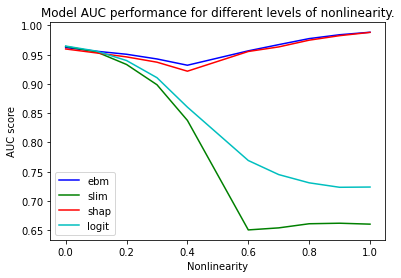

In [210]:
fig, ax1 = plt.subplots()
xlabel = 'balance'
# xlabel = 'noise'
ylabel = 'test'
ax1.set_xlabel('Nonlinearity')
# ax1.set_xlabel('Noise')
ax1.set_ylabel('AUC score')
ax1.plot(xlabel, ylabel, 'b',data=ebm_df)
ax1.plot(xlabel, ylabel, 'g', data=slim_df)
ax1.plot(xlabel, ylabel, 'r', data=shap_df)
ax1.plot(xlabel, ylabel, 'c', data=logit_df)
plt.legend(['ebm', 'slim', 'shap', 'logit'])
plt.title("Model AUC performance for different levels of nonlinearity.")
# plt.title("Model AUC performance for different levels of noise.")
plt.savefig("results\plots\synth_auc.png")
# plt.savefig("results\plots\synth_combined_alt_auc.png")
# plt.savefig("results\plots\synth_noise_auc.png")
# plt.savefig("results\plots\synth_noise_alt_auc.png")
plt.show()

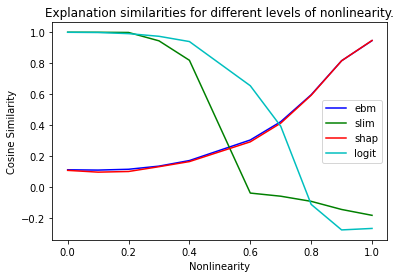

In [211]:
fig, ax1 = plt.subplots()
xlabel = 'balance'
# xlabel = 'noise'
ylabel = 'score'
ax1.set_xlabel('Nonlinearity')
# ax1.set_xlabel('Noise')
ax1.set_ylabel('Cosine Similarity')
ax1.plot(xlabel, ylabel, 'b',data=ebm_df)
ax1.plot(xlabel, ylabel, 'g', data=slim_df)
ax1.plot(xlabel, ylabel, 'r', data=shap_df)
ax1.plot(xlabel, ylabel, 'c', data=logit_df)
plt.legend(['ebm', 'slim', 'shap', 'logit'])
plt.title("Explanation similarities for different levels of nonlinearity.")
# plt.title("Explanation similarities for different levels of noise.")
plt.savefig("results\plots\synth_simil.png")
# plt.savefig("results\plots\synth_noise_simil.png")
# plt.savefig("results\plots\synth_noise_alt_simil.png")
# plt.savefig("results\plots\synth_combined_alt_simil.png")
plt.show()

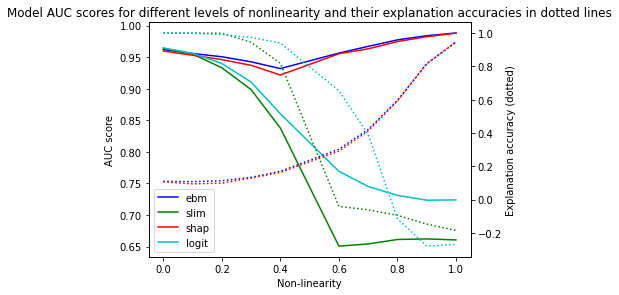

In [67]:
fig, ax1 = plt.subplots()
xlabel = 'balance'
ylabel = 'test'
color = 'tab:red'
ax1.set_xlabel('Non-linearity')
ax1.set_ylabel('AUC score')
ax1.plot(xlabel, ylabel, 'b',data=ebm_df)
ax1.plot(xlabel, ylabel, 'g', data=slim_df)
ax1.plot(xlabel, ylabel, 'r', data=shap_df)
ax1.plot(xlabel, ylabel, 'c', data=logit_df)
ax1.tick_params(axis='y')
plt.legend(['ebm', 'slim', 'shap', 'logit'])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Explanation accuracy (dotted)')  # we already handled the x-label with ax1
ax2.plot(xlabel, 'score', 'b:', data=ebm_df)
ax2.plot(xlabel, 'score', 'g:', data=slim_df)
ax2.plot(xlabel, 'score', 'r:', data=shap_df)
ax2.plot(xlabel, 'score', 'c:', data=logit_df)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Model AUC scores for different levels of nonlinearity and their explanation accuracies in dotted lines")
plt.show()